In [1]:
""" The following import needed to be in the main.ipynb file as they are using local variables that are constantly 
redefined during iteartions
"""

from functions import *
from keras.layers import Embedding
from tensorboard.plugins.hparams import api as hp


def train_deep_model(model,X_train, y_train, X_val, y_val, BATCH_SIZE, EPOCHS, plot, callback,model_name):
    """
    This function handles the training of any deep learning model and saves its history to plot learning curves
    ----------
    model: An oject defining a compiled model
    X_train: The training data obtained through partitioning
    y_train: The training data corresponding labels
    X_val: The validation data obtained through partitioning
    y_val: The validation data corresponding labels
    BATCH_SIZE: The batch size to be used during training 
    EPOCHS: The number of epoch to train models
    plot: Boolean stating if teh learning curves should be plotted
    callback: Boolean defining whether callbacks are used or not
    model_name: A string defining teh model name
    ------
    """
    # load pre-trained word embeddings into an Embedding layer
    # the trainable parameter is set to False so as to keep the embeddings fixed
    if callback is True:
        logdir = os.path.join("logs/"+str(model_name))        
        tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
        cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

        history = model.fit(X_train,
                  to_categorical(y_train),
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(X_val,to_categorical(y_val)),
                  callbacks=[tensorboard_callback,cm_callback])
        
    else:
        history = model.fit(X_train,
                  to_categorical(y_train),
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(X_val,to_categorical(y_val)))

    if plot is True:
        fig,(ax) = plt.subplots(1, 2, figsize=(13,4))
        ax[0].set_title("Training and Validation Accuracy")
        ax[0].plot(history.history['loss'], label='loss')
        ax[0].plot(history.history['val_loss'], label='val_loss')
        ax[0].legend(loc='upper right')

        ax[1].set_title("Training and Validation Accuracy")
        ax[1].plot(history.history['accuracy'], label='acc')
        ax[1].plot(history.history['val_accuracy'], label='val_acc')
        ax[1].legend(loc='lower right')
        plt.show()
    return model
    
def plot_confusion_matrix(cm):
    """
    Plots a heatmap representing the model confusion matrix
    ----------
    cm: A numpy array containing the confusion matrix
    ------
    """
    #class_names = ["Negative","Positive"]
    #class_names = ["Negative","Neutral","Positive"]
    class_names = ["Very Negative","Negative","Neutral","Positive", "Very Positive"]
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Compute the labels from the normalized confusion matrix.
    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure
      
def plot_to_image(figure):
    """
    This funtion is used by TensorFlow callbacks to load confusion matrices during each training iteration
    ----------
    figure: The heatman corresponding to the confusion matrix
    ------
    """
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def log_confusion_matrix(epoch, logs):
    """
    This function leverages teh previous functions to compute the confusion matrix and convert it into a visual
    representation
    ----------
    estimator:
    title:
    X:
    y:
    ------
    """
  # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(X_val)
    test_pred = np.argmax(test_pred_raw, axis=1)
    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(y_val, test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm)
    cm_image = plot_to_image(figure)
    logdir = os.path.join("logs/"+str(model_name))        
    file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# 1- Data Loading and visualisation

In [2]:
df_submission = load_sub_data()
df_submission = df_submission

In [3]:
df_train = load_train_data()
df_train = df_train

2    79582
3    32927
1    27273
4     9206
0     7072
Name: sentiment, dtype: int64


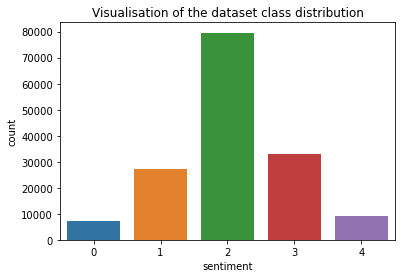

In [4]:
plot_class_distribution(df_train["sentiment"])

# 2- Data pre-processing

### Data cleaning 

In [5]:
df_train = data_cleaning(df_train)

In [6]:
df_submission = data_cleaning(df_submission)

### Transformation to TF-IDF features

In [7]:
best_par = return_best_tfidf(df_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The best ngram range parameters according to GridSearchCV:  {'tfidf__ngram_range': (1, 1)}


In [8]:
X_TfIdf = Tfidf_transformation(df_train,ngram_range= best_par["tfidf__ngram_range"])

Before transformation: The data had shape:  (156060,)
After transformation: The data has shape:  (156060, 16056)


### Transformation to word2Vec features using gensim

In [9]:
X_word2Vec = word2Vec_transform(df_train,False)

100% |########################################################################|


# 3- Data partitionning

### Create sets using the original data

In [10]:
X_train,X_val,X_test,y_train,y_val,y_test = data_partitioning(df_train["review"].values,df_train["sentiment"].values,test_size=0.3,summary=True)

Overall class distribution in this dataset
2    55531
3    23084
1    19174
4     6498
0     4954
dtype: int64
2    11999
3     4830
1     4153
4     1370
0     1057
dtype: int64

X_train has shape: (109241,)
y_train has shape: (109241,)
X_val has shape: (23409,)
y_val has shape: (23409,)
X_test has shape: (23410,)
y_test has shape: (23410,)


### Create sets to be used when converted into TFIDF features

In [11]:
X_train_TfIdf,X_val_TfIdf,X_test_TfIdf,y_train_TfIdf,y_val_TfIdf,y_test_TfIdf = data_partitioning(X_TfIdf,df_train["sentiment"].values,test_size=0.3,summary=False)

### Create sets to be used when converted into Word2Vec features

In [12]:
X_train_word2Vec,X_val_word2Vec,X_test_word2Vec,y_train_word2Vec,y_val_word2Vec,y_test_word2Vec= data_partitioning(X_word2Vec,df_train["sentiment"].values,test_size=0.3, summary=False)

### Create sets to be used when converted into BERT features

In [13]:
X_train_bert,X_val_bert,X_test_bert,y_train_bert,y_val_bert,y_test_bert = data_partitioning(df_train["review"].values,df_train["sentiment"].values,test_size=0.3,summary=False)

# 4- Inference step using Logistic regression

### Sentiment prediction using TF-IDF embeddings

Fitting accuracy
**************************
0.5266703893226902
Prediction accuracy
**************************
0.4946604015378044

************************************************************
                 LR classification report
************************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1003
           1       0.22      0.02      0.04      4136
           2       0.51      0.95      0.66     11935
           3       0.21      0.04      0.06      4885
           4       0.00      0.00      0.00      1451

    accuracy                           0.49     23410
   macro avg       0.19      0.20      0.15     23410
weighted avg       0.34      0.49      0.36     23410



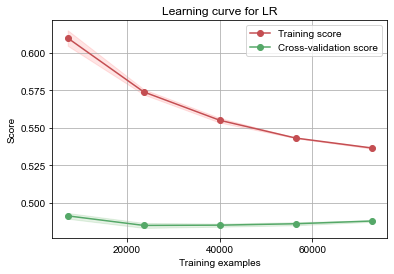

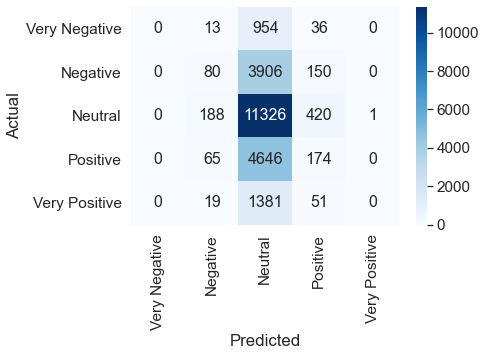

In [14]:
LR_predict(X_train_TfIdf,y_train_TfIdf,X_test_TfIdf,y_test_TfIdf)

### Dimensionality reduction using Truncated Singular Value Decomposition (TSVD)

Initial train matrix shape is:  (109241, 16056)
Initial test shape is:  (23410, 16056)
PCA transformed train shape is:  (109241, 10000)
PCA transformed test shape is:  (23410, 10000)


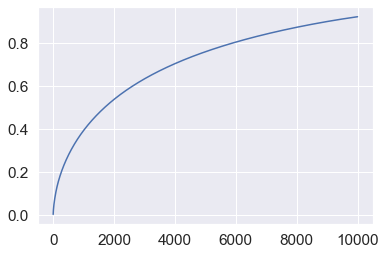

In [15]:
X_train_TfIdf,X_test_TfIdf,tsvd = apply_TSVD(X_train_TfIdf,X_test_TfIdf,True,10000)

### Sentiment prediction using TF-IDF embeddings after diemnsionality reduction

Fitting accuracy
**************************
0.5562746587819591
Prediction accuracy
**************************
0.5530969671080734

************************************************************
                 LR classification report
************************************************************
              precision    recall  f1-score   support

           0       0.50      0.06      0.11      1059
           1       0.45      0.20      0.28      4194
           2       0.58      0.86      0.69     11998
           3       0.48      0.32      0.39      4819
           4       0.47      0.10      0.17      1340

    accuracy                           0.55     23410
   macro avg       0.50      0.31      0.33     23410
weighted avg       0.53      0.55      0.50     23410



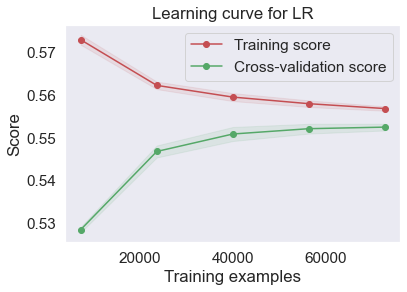

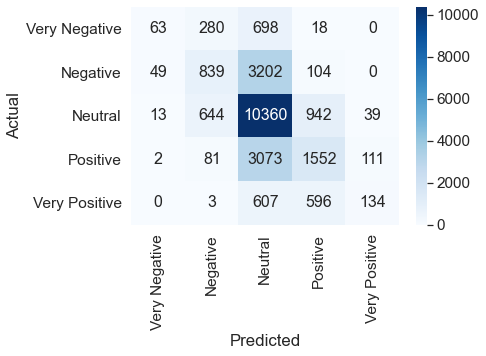

In [15]:
LR_predict(X_train_TfIdf,y_train_TfIdf,X_test_TfIdf,y_test_TfIdf)

### Sentiment prediction using Word2Vec embeddings

Fitting accuracy
**************************
0.6855759284517717
Prediction accuracy
**************************
0.6292609995728321

************************************************************
                 LR classification report
************************************************************
              precision    recall  f1-score   support

           0       0.58      0.18      0.27      1003
           1       0.55      0.35      0.43      4136
           2       0.66      0.88      0.76     11935
           3       0.55      0.46      0.50      4885
           4       0.65      0.24      0.35      1451

    accuracy                           0.63     23410
   macro avg       0.60      0.42      0.46     23410
weighted avg       0.61      0.63      0.60     23410



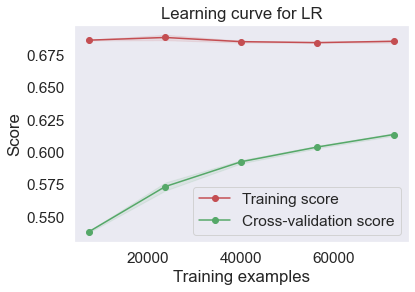

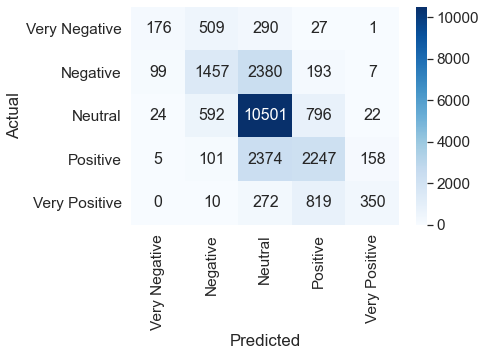

In [16]:
LR_predict(X_train_word2Vec,y_train_word2Vec,X_test_word2Vec,y_test_word2Vec)

# 5- Inference step using Deep Learning

### Data encoding and embedding layer creation with Word2vec

In [17]:
EMBEDDING_DIM,MAX_SEQUENCE_LENGTH,MAX_VOCAB_SIZE,w2v_model,embedding_matrix,X_train,X_val,X_test,X_submission = load_pretrained_embedding_model(df_train,
                                                                                                                                   df_submission, 
                                                                                                                                   X_train, 
                                                                                                                                   X_val,
                                                                                                                                   X_test,
                                                                                                                                   EMBEDDING_DIM = 300, 
                                                                                                                                   model = 'word2vec-google-news-300')

Maximum sentence lenght:  52
Found 19284 unique tokens in the dataset.
Loading word vectors from local file...
Shape of X_train data tensor: (109241, 52)
Shape of X_val data tensor: (23409, 52)
Shape of X_test data tensor: (23410, 52)
Shape of X_submission data tensor: (66292, 52)
Filling pre-trained embeddings...
The final embedding matrix has shape:  (19285, 300)


###### You can alternatively train your own Word2Vec for this specific data as mentionned in the report

In [18]:
# EMBEDDING_DIM,MAX_SEQUENCE_LENGTH,MAX_VOCAB_SIZE, data,w2v_model,embedding_matrix,X_train,X_val,X_test,X_submission =  train_Word2Vec_model(
#                                                                                                         df_train,
#                                                                                                         df_submission,
#                                                                                                         X_train,
#                                                                                                         X_val,
#                                                                                                         X_test,
#                                                                                                         EMBEDDING_DIM, 
#                                                                                                         model)



In [19]:
embedding_layer = Embedding(MAX_VOCAB_SIZE,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

### Simple Long-Short-Term-Memory (LSTM)

In [20]:
def simple_LSTM_model_multiclass(embedding_layer):
    simple_LSTM_model_multiclass = Sequential()
    simple_LSTM_model_multiclass.add(embedding_layer)
    simple_LSTM_model_multiclass.add(LSTM(128))
    simple_LSTM_model_multiclass.add(Dense(5, activation='softmax'))
    simple_LSTM_model_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                         optimizer=Adam(lr=1e-3),
                                         metrics=['accuracy'])
    simple_LSTM_model_multiclass.summary()
    return simple_LSTM_model_multiclass,"simple_LSTM_model_multiclass_trainable"

In [21]:
model, model_name = simple_LSTM_model_multiclass(embedding_layer) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 52, 300)           5785500   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,005,793
Trainable params: 220,293
Non-trainable params: 5,785,500
_________________________________________________________________


Epoch 1/10
854/854 [==============================] - 106s 122ms/step - loss: 1.0455 - accuracy: 0.5791 - val_loss: 0.8971 - val_accuracy: 0.6329
Epoch 2/10
854/854 [==============================] - 100s 117ms/step - loss: 0.8820 - accuracy: 0.6381 - val_loss: 0.8743 - val_accuracy: 0.6374
Epoch 3/10
854/854 [==============================] - 100s 117ms/step - loss: 0.8521 - accuracy: 0.6491 - val_loss: 0.8456 - val_accuracy: 0.6519
Epoch 4/10
854/854 [==============================] - 94s 110ms/step - loss: 0.8184 - accuracy: 0.6645 - val_loss: 0.8367 - val_accuracy: 0.6532
Epoch 5/10
854/854 [==============================] - 88s 103ms/step - loss: 0.7905 - accuracy: 0.6760 - val_loss: 0.8163 - val_accuracy: 0.6613
Epoch 6/10
854/854 [==============================] - 84s 98ms/step - loss: 0.7628 - accuracy: 0.6869 - val_loss: 0.8121 - val_accuracy: 0.6633
Epoch 7/10
854/854 [==============================] - 83s 97ms/step - loss: 0.7330 - accuracy: 0.6986 - val_loss: 0.8074 - val_a

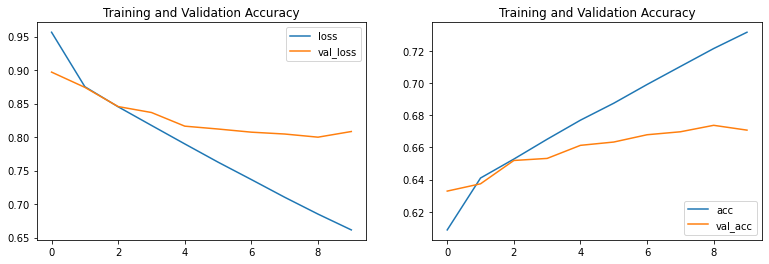

In [22]:
model = train_deep_model(model,
                        X_train,y_train, 
                        X_val, y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 10, 
                        plot=True,
                        callback=True,
                        model_name= model_name)

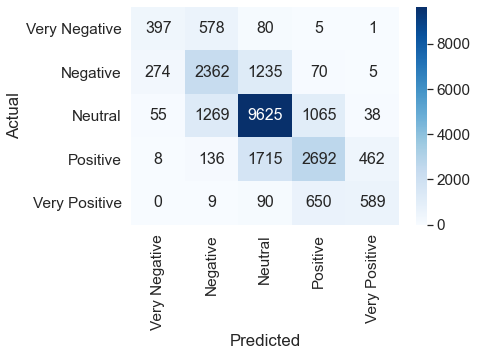

              precision    recall  f1-score   support

           0       0.54      0.37      0.44      1061
           1       0.54      0.60      0.57      3946
           2       0.76      0.80      0.78     12052
           3       0.60      0.54      0.57      5013
           4       0.54      0.44      0.48      1338

    accuracy                           0.67     23410
   macro avg       0.60      0.55      0.57     23410
weighted avg       0.66      0.67      0.66     23410



In [23]:
generate_pred(model,X_test,y_test)

In [24]:
# submission = generate_submission(model,X_submission,df_submission,model_name,False)

### Multi-layer LSTM

In [25]:
def multi_layer_lstm_multiclass(embedding_layer):
    multi_layer_lstm_multiclass = Sequential()
    multi_layer_lstm_multiclass.add(embedding_layer)
    
    multi_layer_lstm_multiclass.add(Bidirectional(LSTM(128, return_sequences=True)))
    multi_layer_lstm_multiclass.add(Dense(64, activation='relu'))
    keras.layers.Dropout(0.5)
    multi_layer_lstm_multiclass.add(Bidirectional(LSTM(128, return_sequences=True)))
    multi_layer_lstm_multiclass.add(Dense(64, activation='relu'))

    multi_layer_lstm_multiclass.add(Bidirectional(LSTM(128, return_sequences=True)))
    multi_layer_lstm_multiclass.add(Dense(32, activation='relu'))
    
    multi_layer_lstm_multiclass.add(GlobalMaxPool1D())
    
    multi_layer_lstm_multiclass.add(Dense(5, activation='softmax'))
    multi_layer_lstm_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                           optimizer=Adam(lr=1e-3),
                                           metrics=['accuracy'])
    
    multi_layer_lstm_multiclass.summary()
    return multi_layer_lstm_multiclass,"multi_layer_lstm_multiclass_no_dense"

In [26]:
model, model_name = multi_layer_lstm_multiclass(embedding_layer)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 52, 300)           5785500   
_________________________________________________________________
bidirectional (Bidirectional (None, 52, 256)           439296    
_________________________________________________________________
dense_1 (Dense)              (None, 52, 64)            16448     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 52, 256)           197632    
_________________________________________________________________
dense_2 (Dense)              (None, 52, 64)            16448     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 52, 256)           197632    
_________________________________________________________________
dense_3 (Dense)              (None, 52, 32)           

Epoch 1/8
854/854 [==============================] - 403s 464ms/step - loss: 1.0707 - accuracy: 0.5711 - val_loss: 0.8793 - val_accuracy: 0.6346
Epoch 2/8
854/854 [==============================] - 388s 454ms/step - loss: 0.8699 - accuracy: 0.6430 - val_loss: 0.8578 - val_accuracy: 0.6415
Epoch 3/8
854/854 [==============================] - 433s 507ms/step - loss: 0.8215 - accuracy: 0.6615 - val_loss: 0.8162 - val_accuracy: 0.6621
Epoch 4/8
854/854 [==============================] - 432s 506ms/step - loss: 0.7760 - accuracy: 0.6809 - val_loss: 0.8024 - val_accuracy: 0.6651
Epoch 5/8
854/854 [==============================] - 439s 514ms/step - loss: 0.7380 - accuracy: 0.6962 - val_loss: 0.7940 - val_accuracy: 0.6723
Epoch 6/8
854/854 [==============================] - 399s 467ms/step - loss: 0.7050 - accuracy: 0.7098 - val_loss: 0.7877 - val_accuracy: 0.6792
Epoch 7/8
854/854 [==============================] - 409s 479ms/step - loss: 0.6799 - accuracy: 0.7210 - val_loss: 0.7881 - val_ac

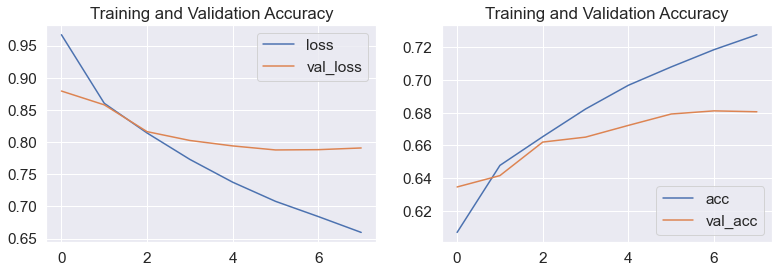

In [27]:
model = train_deep_model(model,
                        X_train,y_train, 
                        X_val, y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 8, 
                        plot=True,
                        callback=True,
                        model_name= model_name)

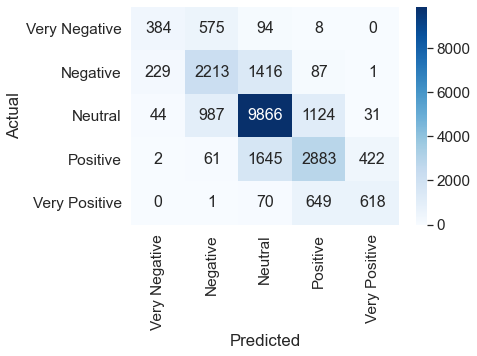

              precision    recall  f1-score   support

           0       0.58      0.36      0.45      1061
           1       0.58      0.56      0.57      3946
           2       0.75      0.82      0.78     12052
           3       0.61      0.58      0.59      5013
           4       0.58      0.46      0.51      1338

    accuracy                           0.68     23410
   macro avg       0.62      0.56      0.58     23410
weighted avg       0.67      0.68      0.68     23410



In [28]:
generate_pred(model,X_test,y_test

In [29]:
# submission = generate_submission(model,X_submission,df_submission,model_name,False)

### CNN with parallelized channels

In [30]:
def parallelized_CNN_multiclass(embedding_layer):
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    tweet_encoder = embedding_layer(input_)
    
    bigram_branch = Conv1D(filters=128, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
    bigram_branch = GlobalMaxPool1D()(bigram_branch)
    bigram_branch = Dense(64)(bigram_branch)

    trigram_branch = Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
    trigram_branch = GlobalMaxPool1D()(trigram_branch)
    trigram_branch = Dense(64)(trigram_branch)

    fourgram_branch = Conv1D(filters=128, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
    fourgram_branch = GlobalMaxPool1D()(fourgram_branch)
    fourgram_branch = Dense(64)(fourgram_branch)

    merged = concatenate([bigram_branch, trigram_branch], axis=1)
    
    merged = Dropout(0.3)(merged)
    merged = Dense(5)(merged)
    output = Activation('softmax')(merged)
    parallelized_CNN_multiclass = Model(inputs=[input_], outputs=[output])

    parallelized_CNN_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                           optimizer=Adam(lr=1e-4),
                                           metrics=['accuracy'])
    
    parallelized_CNN_multiclass.summary()
    return parallelized_CNN_multiclass,"parallelized_CNN_multiclass_ablation"

In [31]:
model, model_name = parallelized_CNN_multiclass(embedding_layer)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 52)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 52, 300)      5785500     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 51, 128)      76928       embedding[2][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 128)      115328      embedding[2][0]                  
______________________________________________________________________________________________

Epoch 1/12
854/854 [==============================] - 31s 36ms/step - loss: 1.2948 - accuracy: 0.4988 - val_loss: 0.9642 - val_accuracy: 0.6119
Epoch 2/12
854/854 [==============================] - 31s 37ms/step - loss: 0.9521 - accuracy: 0.6142 - val_loss: 0.9070 - val_accuracy: 0.6275
Epoch 3/12
854/854 [==============================] - 31s 37ms/step - loss: 0.8914 - accuracy: 0.6396 - val_loss: 0.8771 - val_accuracy: 0.6371
Epoch 4/12
854/854 [==============================] - 35s 41ms/step - loss: 0.8539 - accuracy: 0.6553 - val_loss: 0.8595 - val_accuracy: 0.6458
Epoch 5/12
854/854 [==============================] - 34s 39ms/step - loss: 0.8219 - accuracy: 0.6688 - val_loss: 0.8438 - val_accuracy: 0.6524
Epoch 6/12
854/854 [==============================] - 33s 39ms/step - loss: 0.7988 - accuracy: 0.6810 - val_loss: 0.8328 - val_accuracy: 0.6576
Epoch 7/12
854/854 [==============================] - 33s 39ms/step - loss: 0.7766 - accuracy: 0.6907 - val_loss: 0.8241 - val_accuracy:

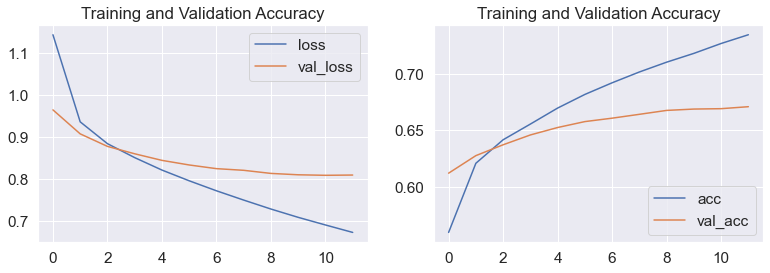

In [32]:
model = train_deep_model(model,
                        X_train,y_train, 
                        X_val, y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 12, 
                        plot=True,
                        callback=True,
                        model_name= model_name )

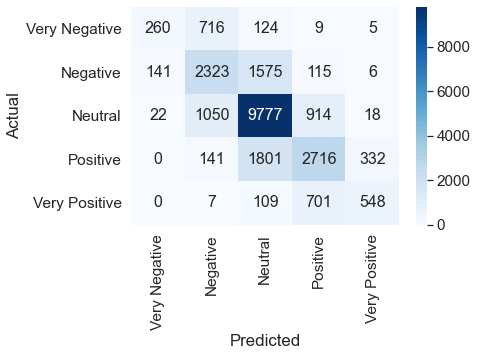

              precision    recall  f1-score   support

           0       0.61      0.23      0.34      1114
           1       0.55      0.56      0.55      4160
           2       0.73      0.83      0.78     11781
           3       0.61      0.54      0.58      4990
           4       0.60      0.40      0.48      1365

    accuracy                           0.67     23410
   macro avg       0.62      0.51      0.55     23410
weighted avg       0.66      0.67      0.66     23410



In [33]:
generate_pred(model,X_test,y_test)

In [34]:
# submission = generate_submission(model,X_submission,df_submission,model_name,False)

### Hybrid model: CNN+LSTM

Quick note: As outlined in the report the final version of the model was fine tuned through a script run on a GPU as the function took more than 20 hours to end. The same applies for data augentation which was saved in a pickle format for convenience. If you wish to run these functions, please run respectively `hypertune_model()` and `back_translation_augmentation()`

In [35]:
train_data = load_pkl("Dataset/Augmented/X_train_aug")
train_data = train_data

y_labels = load_pkl("Dataset/Augmented/y_train_aug")
y_labels = y_labels

In [36]:
def hybrid_LSTM_CNN_multiclass(embedding_layer):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedded_sequences = embedding_layer(sequence_input)
#     embedded_sequences = Dropout(0.2, name='drop_out')(embedded_sequences)
    
    biLSTM_1 = Bidirectional(LSTM(128, return_sequences=True))(embedded_sequences)
    dense_1 = Dense(32, activation='relu', name='dense_1')(biLSTM_1)

    conv_1 = Conv1D(16, 2, activation='relu', name='conv_1')(dense_1)  
    gmp_1 = GlobalMaxPool1D(name='gmp_1')(conv_1)
    
    conv_2 = Conv1D(16, 3, activation='relu', name='conv_2')(dense_1)
    gmp_2 = GlobalMaxPool1D(name='gmp_2')(conv_2)

    concat = concatenate([gmp_1,gmp_2])
    
    mp_dense = Dense(32, activation='relu', name='mp_dense')(concat)
    
    preds = Dense(5, activation='softmax', name='preds')(mp_dense)
    hybrid_LSTM_CNN_multiclass = Model(sequence_input, preds)

    hybrid_LSTM_CNN_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                           optimizer=Adam(lr=0.01),
                                           metrics=['accuracy'])
    
    hybrid_LSTM_CNN_multiclass.summary()
    return hybrid_LSTM_CNN_multiclass,"hybrid_LSTM_CNN_multiclass_dropout_conv_dense"

In [37]:
model, model_name = hybrid_LSTM_CNN_multiclass(embedding_layer)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 52)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 52, 300)      5785500     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 52, 256)      439296      embedding[3][0]                  
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 52, 32)       8224        bidirectional_3[0][0]            
____________________________________________________________________________________________

Epoch 1/6
1144/1144 [==============================] - 178s 154ms/step - loss: 1.1331 - accuracy: 0.5193 - val_loss: 0.8220 - val_accuracy: 0.6669
Epoch 2/6
1144/1144 [==============================] - 180s 157ms/step - loss: 0.9312 - accuracy: 0.6110 - val_loss: 0.7836 - val_accuracy: 0.6836
Epoch 3/6
1144/1144 [==============================] - 182s 159ms/step - loss: 0.8508 - accuracy: 0.6437 - val_loss: 0.7194 - val_accuracy: 0.7090
Epoch 4/6
1144/1144 [==============================] - 181s 158ms/step - loss: 0.8105 - accuracy: 0.6605 - val_loss: 0.7214 - val_accuracy: 0.7058
Epoch 5/6
1144/1144 [==============================] - 183s 160ms/step - loss: 0.7802 - accuracy: 0.6744 - val_loss: 0.6932 - val_accuracy: 0.7244
Epoch 6/6
1144/1144 [==============================] - 184s 160ms/step - loss: 0.8126 - accuracy: 0.6604 - val_loss: 0.7664 - val_accuracy: 0.6934


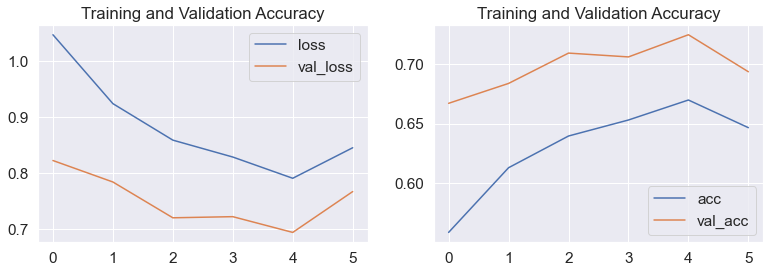

In [38]:
model = train_deep_model(model,
                        train_data,y_labels, 
                        X_val,y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 6, 
                        plot=True,
                        callback=True,
                        model_name= model_name)

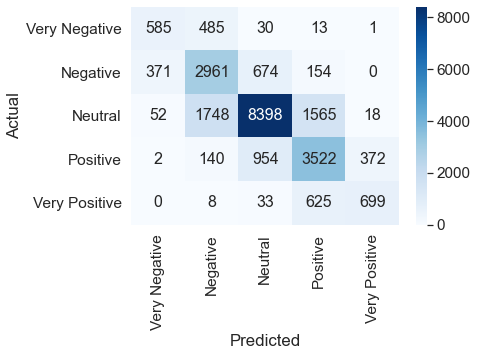

              precision    recall  f1-score   support

           0       0.58      0.53      0.55      1114
           1       0.55      0.71      0.62      4160
           2       0.83      0.71      0.77     11781
           3       0.60      0.71      0.65      4990
           4       0.64      0.51      0.57      1365

    accuracy                           0.69     23410
   macro avg       0.64      0.63      0.63     23410
weighted avg       0.71      0.69      0.69     23410



In [39]:
generate_pred(model,X_test,y_test)

In [40]:
submission = generate_submission(model,X_submission,df_submission,model_name,False)

In [41]:
submission

PhraseId  Sentiment
0        156061          3
1        156062          3
2        156063          2
3        156064          3
4        156065          3
...         ...        ...
66287    222348          1
66288    222349          1
66289    222350          1
66290    222351          1
66291    222352          1

[66292 rows x 2 columns]

# TRANSFORMERS

In [43]:
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [44]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [45]:
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
MAX_SEQUENCE_LENGTH = 150

In [46]:
def build_model(bert_layer, max_len=MAX_SEQUENCE_LENGTH):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.5)(net)
    out = tf.keras.layers.Dense(5, activation='softmax')(net)
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    return model, "bert_model"

In [47]:
train_input = bert_encode(X_train_bert, tokenizer, max_len=MAX_SEQUENCE_LENGTH)
val_input = bert_encode(X_val_bert, tokenizer, max_len=MAX_SEQUENCE_LENGTH)
test_input = bert_encode(X_test_bert, tokenizer, max_len=MAX_SEQUENCE_LENGTH)
sub_input = bert_encode(df_submission.review.values, tokenizer, max_len=MAX_SEQUENCE_LENGTH)

In [48]:
model,model_name = build_model(bert_layer, max_len=MAX_SEQUENCE_LENGTH)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

Epoch 1/3
3642/3642 [==============================] - 2022s 551ms/step - loss: 1.0397 - accuracy: 0.5846 - val_loss: 0.7621 - val_accuracy: 0.6852

Epoch 00001: val_accuracy improved from -inf to 0.68525, saving model to best_bert_model.h5
Epoch 2/3
3642/3642 [==============================] - 2009s 552ms/step - loss: 0.8045 - accuracy: 0.6827 - val_loss: 0.7226 - val_accuracy: 0.7032

Epoch 00002: val_accuracy improved from 0.68525 to 0.70323, saving model to best_bert_model.h5
Epoch 3/3
3642/3642 [==============================] - 2010s 552ms/step - loss: 0.7160 - accuracy: 0.7213 - val_loss: 0.7656 - val_accuracy: 0.6846

Epoch 00003: val_accuracy did not improve from 0.70323


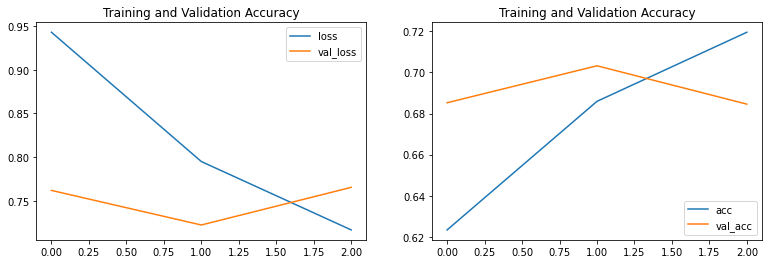

In [49]:
model = train_bert_model(model,
                        train_input,y_train_bert, 
                        val_input,y_val_bert,
                        BATCH_SIZE = 30, 
                        EPOCHS = 3, 
                        plot=True,
                        callback=True,
                        model_name= model_name)

In [52]:
# model = tf.keras.models.load_model('../input/testmodel/model.h5',custom_objects={'KerasLayer':hub.KerasLayer})

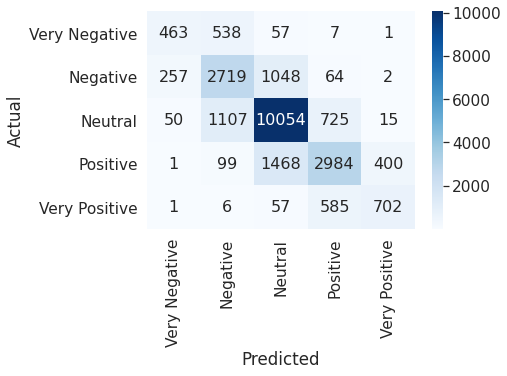

              precision    recall  f1-score   support

           0       0.60      0.43      0.50      1066
           1       0.61      0.66      0.64      4090
           2       0.79      0.84      0.82     11951
           3       0.68      0.60      0.64      4952
           4       0.63      0.52      0.57      1351

    accuracy                           0.72     23410
   macro avg       0.66      0.61      0.63     23410
weighted avg       0.72      0.72      0.72     23410



In [53]:
generate_pred(model,test_input,y_test_bert)

In [54]:
submission = generate_submission(model,sub_input,df_submission,"bert_model_output",False)

PhraseId  Sentiment
0        156061          2
1        156062          2
2        156063          2
3        156064          2
4        156065          3
...         ...        ...
66287    222348          1
66288    222349          1
66289    222350          2
66290    222351          2
66291    222352          1

[66292 rows x 2 columns]